# Deep Q-Learning

References:
- https://www.nervanasys.com/demystifying-deep-reinforcement-learning/

## Create Pong environment

In [1]:
import gym
import numpy as np
from scipy.misc import imresize
from collections import deque

In [2]:
class PongEnv(object):
    def __init__(self, n_states=4):
        self._env = gym.make("Pong-v0")
        # self._env.get_action_meanings()
        # ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
        self._action_map = [2, 3]
        self.n_states = n_states
        self._states = deque(maxlen=self.n_states)
        self.reset()
    
    def _preprocess_image(self, img):
        # convert to grayscale
        img = np.dot(img[...,:3], [0.299, 0.587, 0.114])
        # resize
        img = imresize(img, [60,60])
        
        # scale to 0..1
        img = img / 128.0 - 1
        
        # img = np.expand_dims(img, axis=-1) # add single channel to make it TF friendly
        return img.astype(np.float32)
    
    def reset(self):
        s = self._env.reset()
        s = self._preprocess_image(s)
        
        self._states.clear()
        for _ in range(self.n_states - 1):
            self._states.append(np.zeros_like(s))
        self._states.append(s)
        
        return self.state
    
    @property
    def state(self):
        s = np.array(self._states)
        s = np.transpose(s, [1,2,0]) # CHW -> HWC
        return s
        
    def step(self, action):
        a = self._action_map[action]
        s, r, done, info = self._env.step(a)
        # debug
        if r < 0:
            done = True
        s = self._preprocess_image(s)
        self._states.append(s)
        return self.state, r, done, info
    
    @property
    def action_space(self):
        return gym.spaces.discrete.Discrete(len(self._action_map))
    
    @property
    def observation_space(self):
        s = self.state
        return gym.spaces.box.Box(s.min(),
                                  s.max(),
                                  s.shape)

In [3]:
env = PongEnv()
# env = gym.make('CartPole-v0')
# env = gym.make('MountainCar-v0')

[2017-01-21 22:19:46,517] Making new env: Pong-v0


## Create agent

In [4]:
from os import path
import numpy as np
import random
import tensorflow as tf
from tensorflow.contrib import slim

In [5]:
def build_small_fc_q_net(states, n_actions):
    """Build small fully connected Q-network"""
    states_flat = slim.flatten(states)
    layer1 = slim.fully_connected(states_flat,
                                  64,
                                  activation_fn=tf.nn.relu, scope='layer1')
    q = slim.fully_connected(layer1,
                             n_actions,
                             activation_fn=None, scope='layer2')
    return q, [layer1]

def build_large_fc_q_net(states, n_actions):
    """Build 'large' fully connected Q-network"""
    states_flat = slim.flatten(states)
    layer1 = slim.fully_connected(states_flat,
                                  200,
                                  activation_fn=tf.nn.relu, scope='layer1')
    q = slim.fully_connected(layer1,
                             n_actions,
                             activation_fn=None, scope='layer2')
    return q, [layer1]

def build_cnn_q_net(states, n_actions):
    """Build CNN Q-network"""
    initializer = tf.truncated_normal_initializer(0, 0.1)
    l1 = slim.conv2d(states, 32, [8, 8], stride=4, padding='SAME',
                        activation_fn=tf.nn.relu, weights_initializer=initializer, scope='layer1')
    l2 = slim.conv2d(l1, 64, [4, 4], stride=2, padding='SAME',
                        activation_fn=tf.nn.relu, weights_initializer=initializer, scope='layer2')
    l2_flat = slim.flatten(l2)
    l3 = slim.fully_connected(l2_flat, 512, activation_fn=tf.nn.relu,
                              weights_initializer=initializer, scope='layer3')
    q = slim.fully_connected(l3, n_actions, activation_fn=None,
                             weights_initializer=initializer, scope='q_layer')
    return q, [l1, l2, l2_flat, l3]

In [6]:
class Agent(object):
    def __init__(self, n_actions, state_shape, discount=0.99, max_reward=1.0,
                 lr_decay_factor=0.9, init_lr=1e-3, lr_decay_steps=1e3, lr_min=1e-7,
                 min_epsilon=0.05, epsilon_decay_duration=1e4, start_training=1e3,
                 train_freq=1,
                 q_net_builder_fn=build_small_fc_q_net,
                 summary_update_frequency=1000,
                 mem_capacity=10000, batch_size=8, logs_dir='./dqn_logs'):
        self.n_actions = n_actions
        self.discount = discount
        self.max_reward = max_reward
        self.start_training = start_training
        self.train_freq = train_freq
        self.summary_update_frequency = summary_update_frequency
        self.mem_capacity = mem_capacity
        self.mem = []
        self.batch_size = batch_size
        self.graph = tf.Graph()
        self.i = 0
        with self.graph.as_default():
            # add batch dimension
            state_shape = [None] + list(state_shape)
            
            with tf.name_scope('inputs'):
                self.state = tf.placeholder(tf.float32, shape=state_shape)
                self.action = tf.placeholder(tf.int32, shape=[None])
                # self.reward = tf.placeholder(tf.float32, shape=[None])
                # self.state_ = tf.placeholder(tf.float32, shape=state_shape)
                # self.terminal = tf.placeholder(tf.float32, shape=[None])
            
            with tf.variable_scope('q_net'):
                self.q, self.q_net = q_net_builder_fn(self.state, n_actions)
            
#             with tf.variable_scope('q_net', reuse=True):
#                 self.q_t = q_net_builder_fn(self.state_, n_actions)
#                 # self.q_t = tf.stop_gradient(self.q_t) # we do not train q_target_net
            
            with tf.name_scope('loss'):
                # debug
                self.q_target = tf.placeholder(tf.float32, shape=[None])
                # q_t_max = tf.reduce_max(self.q_t, reduction_indices=-1)
                # q_target = (1. - self.terminal) * self.discount * q_t_max + self.reward
                
                mask = tf.one_hot(self.action, n_actions, dtype=tf.float32)
                q_acted = tf.reduce_sum(self.q * mask, reduction_indices=-1)
                # idx = tf.range(0, limit=n_actions*batch_size, delta=n_actions) + self.action
                # q_flat = tf.reshape(self.q, shape=[-1])
                # q_acted = tf.gather(q_flat, idx, validate_indices=True)
                                
                assert self.q_target.get_shape().is_compatible_with(q_acted.get_shape())
                
                diff = q_acted - self.q_target
                tf.histogram_summary("diff", diff)
                # debug
#                 clipped = tf.select(tf.abs(diff) < max_reward,
#                                     0.5 * tf.square(diff),
#                                     tf.abs(diff) - 0.5, name='clipped')
                clipped = tf.square(diff)
                self.error = tf.reduce_sum(clipped)
                tf.scalar_summary("error", self.error)
            
            with tf.name_scope('trainer'):
                self.global_step = tf.Variable(0, trainable=False, name='global_step')
                
                global_step_1 = self.global_step + 1
                self.global_step_inc = self.global_step.assign(global_step_1)
                
                exp_lr = tf.train.exponential_decay(init_lr,
                                                    self.global_step,
                                                    lr_decay_steps,
                                                    lr_decay_factor,
                                                    staircase=True)
                
                self.lr = tf.maximum(lr_min, exp_lr)
                tf.scalar_summary("learning_rate", self.lr)
                # debug
                # opt = tf.train.RMSPropOptimizer(self.lr, momentum=0.95, epsilon=0.01)
                opt = tf.train.AdamOptimizer(self.lr)
                self.train_op = opt.minimize(self.error)
                
                # piggy back on lr to update epsilon (exploration probability)
                gs_float = tf.cast(self.global_step, tf.float32)
                self.epsilon = 1.0 - gs_float / epsilon_decay_duration # start with 1.0 and decay
                self.epsilon = tf.maximum(min_epsilon, self.epsilon)
                tf.scalar_summary("epsilon", self.epsilon)
            
            with tf.name_scope('summary'):
                tf.histogram_summary('q_val', self.q)
                # tf.histogram_summary('action', tf.argmax(self.q, axis=1))
                tf.histogram_summary('q_target_val', self.q_target)
                if len(self.state.get_shape()) == 4:
                    tf.image_summary('states', self.state, max_images=4)
                
                self.total_reward = tf.placeholder(tf.float32, shape=())
                self.game_steps = tf.placeholder(tf.float32, shape=())
                ema = tf.train.ExponentialMovingAverage(0.5)
                self.ema_op = ema.apply([self.total_reward, self.game_steps])
                tf.scalar_summary("total_reward_avg", ema.average(self.total_reward))
                tf.scalar_summary("game_steps_avg", ema.average(self.game_steps))
                
                with tf.name_scope('q_net_weights'):
                    q_net_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='q_net')
                    for v in q_net_vars:
                        name = v.op.name.replace('q_net/', 'q_net_weights/')
                        tf.histogram_summary(name, v)
                with tf.name_scope('q_net_activations'):
                    for o in self.q_net:
                        name = o.op.name.replace('q_net/', 'q_net_activations/')
                        tf.histogram_summary(name + '/activation', o)
                        # tf.scalar_summary(o.op.name + '/sparsity', tf.nn.zero_fraction(o))

                self.summary_op = tf.merge_all_summaries()
                
            init = tf.global_variables_initializer()
            self.saver = tf.train.Saver(max_to_keep=20)
            
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(init)
        
        self.logs_dir = logs_dir
        self.summary_writer = tf.train.SummaryWriter(self.logs_dir, graph=self.graph)
        self.checkpoint_path = path.join(self.logs_dir, 'model.ckpt')
        
        ckpt = tf.train.get_checkpoint_state(self.logs_dir)
        if ckpt and ckpt.model_checkpoint_path:
            self.saver.restore(self.sess, ckpt.model_checkpoint_path)
            print('restoring at global_step = %d' % self.sess.run(self.global_step))
                
    def predict_action(self, state):
        ep_val, self.i = self.sess.run([self.epsilon, self.global_step_inc])
        if np.random.rand() < ep_val:
            return np.random.randint(0, self.n_actions)

        state = np.expand_dims(state, 0)
        q_val = self.sess.run(self.q, feed_dict={self.state: state})[0]
        return np.argmax(q_val)
    
    def observe(self, state, action, reward, state_, terminal):
        self.mem.append((state, action, reward, state_, terminal))
        if len(self.mem) > self.mem_capacity:
            self.mem.pop(0)
    
    def train(self):
        if self.batch_size > len(self.mem): return
        if self.i % self.train_freq != 0: return
        
        samples = random.sample(self.mem, self.batch_size)
        s, a, r, s_, t = zip(*samples)
        
        s = np.array(s, dtype=np.float32)
        s_ = np.array(s_, dtype=np.float32)
        
        # debug
        sess = self.sess
        r = np.array(r, dtype=np.float32)
        t = np.array(t, dtype=int)
        q_t = sess.run(self.q, {self.state: s_})
        
        q_t_max = np.max(q_t, axis=-1)
        q_target = (1. - t) * self.discount * q_t_max + r
                
        feed_dict = {self.state: s,
                     self.action: a,
                     # self.reward: r,
                     # self.state_: s_,
                     # self.terminal: t
                     self.q_target: q_target
                    }
        
        
        if True or self.i >= self.start_training:
            _, err_val = sess.run([self.train_op, self.error], feed_dict)
            assert not np.isnan(err_val), 'Model diverged with loss = NaN'
        
        if self.i % self.summary_update_frequency == 0:
            summary_str = sess.run(self.summary_op, feed_dict)
            self.summary_writer.add_summary(summary_str, self.i)
            self.summary_writer.flush()
        
        if self.i % (5 * self.summary_update_frequency) == 0:
            self.saver.save(sess,
                            self.checkpoint_path,
                            global_step=self.global_step)
    
    def summary_stats(self, total_reward, game_steps):
        feed_dict = {self.total_reward: total_reward, 
                     self.game_steps: game_steps}
        self.sess.run(self.ema_op, feed_dict)

In [7]:
!rm -rf ./dqn_logs*

In [8]:
# agent = Agent(env.action_space.n, env.observation_space.shape,
#               start_training=0, max_reward=100.0)

In [9]:
agent = Agent(env.action_space.n, env.observation_space.shape,
              max_reward=2.0, start_training=1e4,
              lr_decay_steps=2e5, epsilon_decay_duration=2e5,
              q_net_builder_fn=build_cnn_q_net, train_freq=4,
              summary_update_frequency=5000, logs_dir='./dqn_logs_new_q_optim_delayed_start')

## Train agent

In [10]:
from tqdm import tqdm

In [34]:
for game in tqdm(range(50000)):
    s = env.reset()
    steps = 0
    total_reward = 0
    while True:
        a = agent.predict_action(s)
        s_, r, done, info = env.step(a)
        agent.observe(s, a, r, s_, done)
        s = s_
        total_reward += r
        agent.train()

        steps += 1
        if done:
            agent.summary_stats(total_reward, steps)
            break

 94%|█████████▍| 47175/50000 [36:17:33<2:41:51,  3.44s/it]


KeyboardInterrupt: 

In [12]:
s, a, r, s_, t = zip(*agent.mem)

In [13]:
np.array(a).mean()

0.61199999999999999

In [14]:
np.array(t).mean()

0.0054999999999999997

In [15]:
s = env.reset()

In [16]:
samples = random.sample(agent.mem, agent.batch_size)

s, a, r, s_, t = zip(*samples)
        
s = np.array(s, dtype=np.float32)
s_ = np.array(s_, dtype=np.float32)
        
# debug
sess = agent.sess
r = np.array(r, dtype=np.float32)
t = np.array(t, dtype=int)
q_t = sess.run(agent.q, {agent.state: s_})

q_t_max = np.max(q_t, axis=-1)
q_target = (1. - t) * agent.discount * q_t_max + r

In [17]:
q_t

array([[-0.07994294, -0.102292  ],
       [-0.12252456, -0.12732518],
       [-0.69395757, -0.67708319],
       [-0.19261444, -0.19532615],
       [-0.17410833, -0.15542662],
       [-0.08759212, -0.10275644],
       [-0.66686499, -0.69425732],
       [-0.12328768, -0.1318481 ]], dtype=float32)

In [18]:
q = sess.run(agent.q, {agent.state: s})

In [19]:
q

array([[-0.12744415, -0.13666874],
       [-0.130696  , -0.10960853],
       [-0.47380066, -0.34701461],
       [-0.19242728, -0.20450848],
       [-0.20565909, -0.18507099],
       [-0.07686377, -0.09224242],
       [-0.56720948, -0.57382506],
       [-0.11671811, -0.12521726]], dtype=float32)

In [20]:
diff = q[range(agent.batch_size), a] - q_target

In [21]:
diff

array([-0.04830064,  0.01169078,  0.32329776, -0.01382019, -0.03119864,
        0.00985244,  0.09298686, -0.00316246])

In [22]:
(diff**2).sum()

0.11690904530230906

In [23]:
error = sess.run(agent.error, {agent.state: s, agent.action: a, agent.q_target: q_target})
error

0.11690905

In [24]:
total_reward

-1.0

In [25]:
im = sess.run(agent.q_net[2], {agent.state: s})
im.shape

(8, 4096)

In [26]:
tmp = (im[0] - im[5])
tmp.min(), tmp.max(), tmp.mean()

(-0.25952131, 0.34683761, 8.1326871e-05)

In [27]:
# import matplotlib so Gym's render() works nicely with Jupyter
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
s = env.reset()

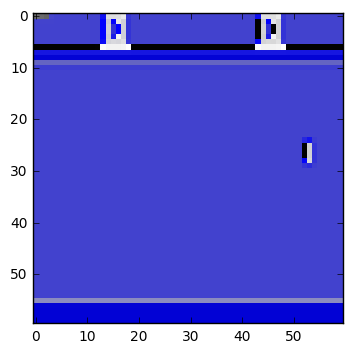

In [29]:
s, r, done, info = env.step(0)
plt.imshow(s[...], cmap='gray', interpolation='none', vmin=-1, vmax=1)

In [30]:
# observation, reward, done, info = env.step(2)
# I = env.render(mode='rgb_array')
# plt.imshow(I)